In [2]:
import xarray as xr

filename = '../data_store/data/SCFG/dap.ceda.ac.uk/2018/10/20181001-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0.nc'

# Open the NetCDF file using xarray
data = xr.open_dataset(filename)

# Display the dataset
# data.close()

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Define the latitude and longitude boundaries for the region of interest
lat_min, lat_max = 67.361833 - 1, 67.361833 + 1
lon_min, lon_max = 26.634154 - 1, 26.634154 + 1

# Select the subset of the data within the specified region
scfg_subset = data['scfg'].sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max)).isel(time=0)

# Set values greater than 100 (which represent flags) to NaN
scfg_subset_cleaned = scfg_subset.where(scfg_subset <= 100)

# # Plot the subset data with flag values set to NaN
# plt.figure(figsize=(10, 6))
# scfg_subset_cleaned.plot(cmap='viridis')
# plt.title(f'SCFG Data on 2018-10-01 for Sodankyla')
# plt.show()

# Define the exact latitude and longitude of interest
lat_val = 67.361833
lon_val = 26.634154

# Select the value at the specified latitude and longitude
scfg_value = scfg_subset_cleaned.sel(lat=lat_val, lon=lon_val, method='nearest').values

# Display the value
print(f"SCFG value at (lat={lat_val}, lon={lon_val}): {scfg_value}")

SCFG value at (lat=67.361833, lon=26.634154): nan


# SCFG

In [17]:
import pandas as pd
import xarray as xr
import numpy as np
from datetime import datetime
import os

df=pd.read_pickle('dataset.pkl')

values = [[] for _ in range(6)]
coords = [(26.634154, 67.361833), (-145.7514, 63.8811), (-93.4541, 47.5049), 
          (-71.6696, 46.9521), (7.5609, 45.8238), (-121.606, 44.3238)]

start_date = '01/10/2018'
end_date = '31/12/2020'

# Convert strings to datetime objects
start = datetime.strptime(start_date, '%d/%m/%Y')
end = datetime.strptime(end_date, '%d/%m/%Y')

# Generate the array of dates
date_array = [(start + pd.Timedelta(days=i)).strftime('%Y%m%d') 
              for i in range((end - start).days + 1)]

def compute_scfg_value(scfg_data, coord, radius_km=2, threshold=100, default_value=200):
    """
    Compute the SCFG value as the average of values ≤ threshold within a radius_km,
    or set to default_value if all values exceed the threshold.

    Parameters:
        scfg_data (xarray.DataArray): The dataset with SCFG values and spatial dimensions (lat, lon).
        coord (tuple): The coordinate as (lon, lat) for which the value is computed.
        radius_km (float): The radius in kilometers to search around the given coordinate (default: 2).
        threshold (float): The maximum value to include in the average (default: 100).
        default_value (float): The value to assign if all values exceed the threshold (default: 200).

    Returns:
        float: The computed SCFG value.
    """
    # Unpack coordinates
    lon, lat = coord

    # Convert radius from kilometers to degrees
    radius_deg_lat = radius_km / 111.0  # 1 degree latitude ≈ 111 km
    radius_deg_lon = radius_km / (111.0 * np.cos(np.radians(lat)))  # Adjust for latitude

    # Subset the data within the radius
    subset = scfg_data.sel(
        lat=slice(lat - radius_deg_lat, lat + radius_deg_lat),
        lon=slice(lon - radius_deg_lon, lon + radius_deg_lon)
    )

    # Mask values greater than the threshold
    valid_values = subset.where(subset <= threshold, drop=True)

    # Calculate the average or assign the default value
    if valid_values.size > 0:  # If there are valid values
        return valid_values.mean().item()
    else:  # If all values exceed the threshold
        return default_value

for j, date in enumerate(date_array):
    # print(date)
    year = date[:4]
    month = date[4:6]

    file_path = f'../data_store/data/SCFG/dap.ceda.ac.uk/{year}/{month}/{date}-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0.nc'

    # if not os.path.exists(file_path):
    #     print('No')
    #     for i, coord in enumerate(coords):
            

    try:
        dataset = xr.open_dataset(file_path)
    except Exception as e:
        print(f"Failed to open {file_path}: {e}")
        for i in range(len(coords)):
            if j != 0:
                values[i].append(values[i][-1])
            else:
                values[i].append(np.nan)
        continue
    scfg_data = dataset['scfg']

    for i, coord in enumerate(coords):
        scfg_value = compute_scfg_value(scfg_data, coord, radius_km=1)

        if j == 0:
            if scfg_value <= 100:
                values[i].append(scfg_value)
            else:
                values[i].append(np.nan)
        else:
            if scfg_value <= 100:
                values[i].append(scfg_value)
            else:
                values[i].append(values[i][-1])

date_array = [datetime.strptime(date, '%Y%m%d') for date in date_array]
# values

Failed to open ../data_store/data/SCFG/dap.ceda.ac.uk/2018/12/20181205-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0.nc: [Errno 2] No such file or directory: '/home/s1803229/data_store/data/SCFG/dap.ceda.ac.uk/2018/12/20181205-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0.nc'


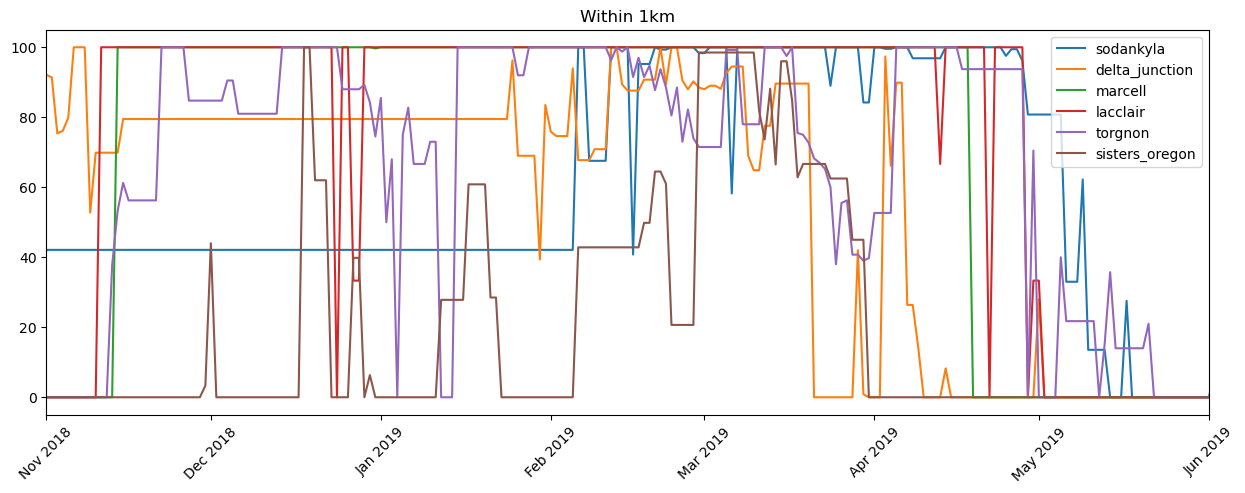

In [18]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
labels = ['sodankyla', 'delta_junction', 'marcell', 'lacclair', 'torgnon', 'sisters_oregon']
plt.figure(figsize=(15,5))
for i, array in enumerate(values):
    plt.plot(date_array, array, label=labels[i])

# Formatting the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks on the first of each month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format ticks as YYYY-MM-DD
plt.xticks(rotation=45)  # Rotate tick labels by 45 degrees

# Set x-axis limits
start_limit = datetime.strptime('20181101', '%Y%m%d')  # October 1st, 2018
end_limit = datetime.strptime('20190601', '%Y%m%d')    # January 1st, 2021
ax.set_xlim([start_limit, end_limit])

plt.legend(loc='upper right')
plt.title('Within 1km')
plt.show()

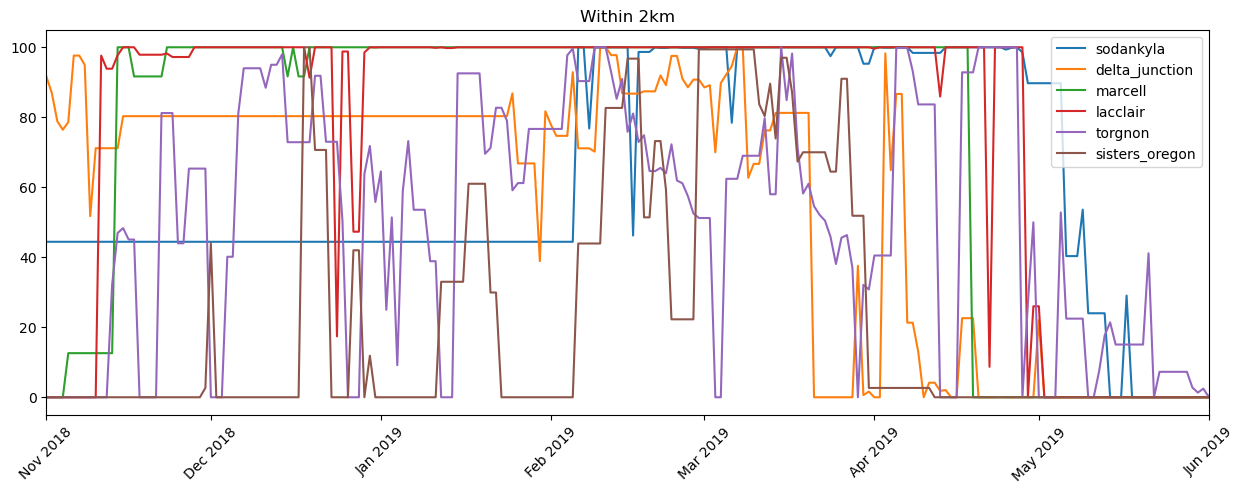

In [16]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
labels = ['sodankyla', 'delta_junction', 'marcell', 'lacclair', 'torgnon', 'sisters_oregon']
plt.figure(figsize=(15,5))
for i, array in enumerate(values):
    plt.plot(date_array, array, label=labels[i])

# Formatting the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks on the first of each month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format ticks as YYYY-MM-DD
plt.xticks(rotation=45)  # Rotate tick labels by 45 degrees

# Set x-axis limits
start_limit = datetime.strptime('20181101', '%Y%m%d')  # October 1st, 2018
end_limit = datetime.strptime('20190601', '%Y%m%d')    # January 1st, 2021
ax.set_xlim([start_limit, end_limit])

plt.legend(loc='upper right')
plt.title('Within 2km')
plt.show()

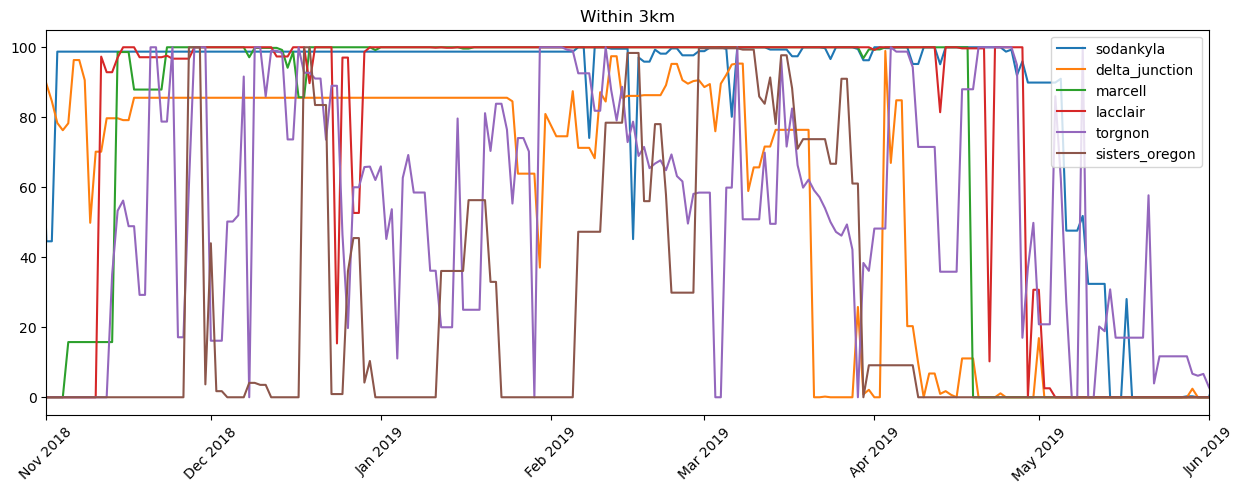

In [13]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
labels = ['sodankyla', 'delta_junction', 'marcell', 'lacclair', 'torgnon', 'sisters_oregon']
plt.figure(figsize=(15,5))
for i, array in enumerate(values):
    plt.plot(date_array, array, label=labels[i])

# Formatting the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks on the first of each month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format ticks as YYYY-MM-DD
plt.xticks(rotation=45)  # Rotate tick labels by 45 degrees

# Set x-axis limits
start_limit = datetime.strptime('20181101', '%Y%m%d')  # October 1st, 2018
end_limit = datetime.strptime('20190601', '%Y%m%d')    # January 1st, 2021
ax.set_xlim([start_limit, end_limit])

plt.legend(loc='upper right')
plt.title('Within 3km')
plt.show()

In [38]:
date_array

['20181001',
 '20181002',
 '20181003',
 '20181004',
 '20181005',
 '20181006',
 '20181007',
 '20181008',
 '20181009',
 '20181010',
 '20181011',
 '20181012',
 '20181013',
 '20181014',
 '20181015',
 '20181016',
 '20181017',
 '20181018',
 '20181019',
 '20181020',
 '20181021',
 '20181022',
 '20181023',
 '20181024',
 '20181025',
 '20181026',
 '20181027',
 '20181028',
 '20181029',
 '20181030',
 '20181031',
 '20181101',
 '20181102',
 '20181103',
 '20181104',
 '20181105',
 '20181106',
 '20181107',
 '20181108',
 '20181109',
 '20181110',
 '20181111',
 '20181112',
 '20181113',
 '20181114',
 '20181115',
 '20181116',
 '20181117',
 '20181118',
 '20181119',
 '20181120',
 '20181121',
 '20181122',
 '20181123',
 '20181124',
 '20181125',
 '20181126',
 '20181127',
 '20181128',
 '20181129',
 '20181130',
 '20181201',
 '20181202',
 '20181203',
 '20181204',
 '20181205',
 '20181206',
 '20181207',
 '20181208',
 '20181209',
 '20181210',
 '20181211',
 '20181212',
 '20181213',
 '20181214',
 '20181215',
 '20181216',

In [3]:
import pandas as pd
import xarray as xr
import numpy as np
from datetime import datetime
import os

df=pd.read_pickle('five_sites_data_snow.pkl')

# df['SCFG'] = None
# df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]

print(df['date'].unique().shape[0])
for i in range(100,174):
    print(df['date'].unique()[i])
    
    # Function to convert date string from 'dd/mm/yyyy' to 'yyyymmdd'
    def format_date_to_filename(date_str):
        return datetime.strptime(date_str, '%d/%m/%Y').strftime('%Y%m%d')
    
    file_date = format_date_to_filename(df['date'].unique()[i])
    year = file_date[:4]
    month = file_date[4:6]
    file_path = f'../data_store/data/SCFG/dap.ceda.ac.uk/{year}/{month}/{file_date}-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0.nc'
    
    if not os.path.exists(file_path):
        print('No')
    
    else:
        dataset = xr.open_dataset(file_path)
        scfg_data = dataset['scfg']
        
        for index, row in df.iterrows():
            if row['date'] == df['date'].unique()[i]:
                scfg_value_array = scfg_data.sel(lat=row['latitude'], lon=row['longitude'], method='nearest').isel(time=0).values
                scfg_value = scfg_value_array.item() if isinstance(scfg_value_array, np.ndarray) else scfg_value_array
                if scfg_value > 100:
                    df.loc[index, 'SCFG'] = None
                else:
                    df.loc[index, 'SCFG'] = scfg_value
                # print(type(scfg_value))
    
    print(df[df['date'] == df['date'].unique()[i]]['SCFG'])
df.to_pickle('five_sites_data_snow.pkl')

# df[df['date'] == df['date'].unique()[i]]['SCFG']

['2018-10-01' '2018-10-02' '2018-10-03' '2018-10-04' '2018-10-05'
 '2018-10-06' '2018-10-07' '2018-10-08' '2018-10-09' '2018-10-10'
 '2018-10-11' '2018-10-12' '2018-10-13' '2018-10-14' '2018-10-15'
 '2018-10-16' '2018-10-17' '2018-10-18' '2018-10-19' '2018-10-20'
 '2018-10-21' '2018-10-22' '2018-10-23' '2018-10-24' '2018-10-25'
 '2018-10-26' '2018-10-27' '2018-10-28' '2018-10-29' '2018-10-30'
 '2018-10-31' '2018-11-01' '2018-11-02' '2018-11-03' '2018-11-04'
 '2018-11-05' '2018-11-06' '2018-11-07' '2018-11-08' '2018-11-09'
 '2018-11-10' '2018-11-11' '2018-11-12' '2018-11-13' '2018-11-14'
 '2018-11-15' '2018-11-16' '2018-11-17' '2018-11-18' '2018-11-19'
 '2018-11-20' '2018-11-21' '2018-11-22' '2018-11-23' '2018-11-24'
 '2018-11-25' '2018-11-26' '2018-11-27' '2018-11-28' '2018-11-29'
 '2018-11-30' '2018-12-01' '2018-12-02' '2018-12-03' '2018-12-04'
 '2018-12-05' '2018-12-06' '2018-12-07' '2018-12-08' '2018-12-09'
 '2018-12-10' '2018-12-11' '2018-12-12' '2018-12-13' '2018-12-14'
 '2018-12-

# SCFV

In [18]:
import pandas as pd
import xarray as xr
import numpy as np
from datetime import datetime
import os

df=pd.read_pickle('five_sites_data_snow.pkl')

df['SCFV'] = None
# df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]

print(df['date'].unique().shape[0])
for i in range(174):
    print(i)
    print(df['date'].unique()[i])
    
    # Function to convert date string from 'dd/mm/yyyy' to 'yyyymmdd'
    def format_date_to_filename(date_str):
        return datetime.strptime(date_str, '%d/%m/%Y').strftime('%Y%m%d')
    
    file_date = format_date_to_filename(df['date'].unique()[i])
    year = file_date[:4]
    month = file_date[4:6]
    file_path = f'../data_store/data/SCFV/dap.ceda.ac.uk/{year}/{month}/{file_date}-ESACCI-L3C_SNOW-SCFV-MODIS_TERRA-fv2.0.nc'
    
    if not os.path.exists(file_path):
        print('No')
    
    else:
        dataset = xr.open_dataset(file_path)
        scfv_data = dataset['scfv']
        
        for index, row in df.iterrows():
            if row['date'] == df['date'].unique()[i]:
                scfv_value_array = scfv_data.sel(lat=row['latitude'], lon=row['longitude'], method='nearest').isel(time=0).values
                scfv_value = scfv_value_array.item() if isinstance(scfv_value_array, np.ndarray) else scfv_value_array
                if scfv_value > 100:
                    df.loc[index, 'SCFV'] = None
                else:
                    df.loc[index, 'SCFV'] = scfv_value
                # print(type(scfg_value))
    
    print(df[df['date'] == df['date'].unique()[i]]['SCFV'])
df.to_pickle('five_sites_data_snow.pkl')

# df[df['date'] == df['date'].unique()[i]]['SCFG']

174
0
12/01/2019
0      None
1      None
2      None
3      None
4      None
       ... 
98     None
99     None
100    None
101    None
102    None
Name: SCFV, Length: 103, dtype: object
1
24/01/2019
103    None
104    None
105    None
106    None
107    None
       ... 
232    None
233    None
234    None
235    None
236    None
Name: SCFV, Length: 134, dtype: object
2
27/03/2019
237    None
238    None
239    None
240    None
241    None
242    None
243    None
244    None
245    None
246    None
Name: SCFV, dtype: object
3
13/04/2019
247    None
248    None
249    None
250    None
251    None
       ... 
331    58.0
332    58.0
333    58.0
334    40.0
335    40.0
Name: SCFV, Length: 89, dtype: object
4
25/04/2019
336    None
337    None
338    39.0
339    None
340    None
341    None
342    None
343    None
344    None
345    None
346    39.0
347    39.0
348    39.0
349    35.0
350    35.0
351    35.0
352    35.0
353    37.0
354    37.0
355    35.0
356    35.0
357    37.0
358    43